In [15]:
import os
import subprocess

from dotenv import load_dotenv
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.ndimage import zoom

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
load_dotenv()
base_dir = os.getenv('BASE_DIR')
ct_dir = os.path.join(base_dir, 'microCT')

In [8]:
input_ct_path = os.path.join(ct_dir, 'MASK_Marmoset1_skull_200micron.nii.gz')
output_ct_path = os.path.join(ct_dir, 'MASK_Marmoset1_skull_ct_2mm.nii.gz')

# desphinxify

In [14]:
os.chdir(ct_dir)

!desphinxify -orient_mid RIP -input MASK_Marmoset1_skull_200micron.nii.gz -prefix MASK_Marmoset1_skull_200micron_DSPH.nii.gz


++ Making working directory: ./__workdir_desphinxify_z2BoCOo49XO
++ 3dcalc: AFNI version=AFNI_24.1.16 (Jun  6 2024) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset ././__workdir_desphinxify_z2BoCOo49XO/__tmp_00_copy.nii
++ 3drefit: AFNI version=AFNI_24.1.16 (Jun  6 2024) [64-bit]
++ Authored by: RW Cox
++ Processing AFNI dataset __tmp_01.nii
 + changing orientation codes
 + loading and re-writing dataset __tmp_01.nii (/Users/yibeichen/Desktop/fusi/microCT/__workdir_desphinxify_z2BoCOo49XO/__tmp_01.nii in NIFTI storage)
++ 3drefit processed 1 datasets
++ 3dcopy: AFNI version=AFNI_24.1.16 (Jun  6 2024) [64-bit]
++ Clean working dir

++ DONE. See the output:
   /Users/yibeichen/Desktop/fusi/microCT/MASK_Marmoset1_skull_200micron_DSPH.nii.gz"



# invert the template brightness

In [16]:
atlas_dir = os.path.join(base_dir, 'atlas')
os.chdir(atlas_dir)

!3dcopy template_t1w.nii.gz template_t1w_afni

result = subprocess.run(['3dBrickStat', '-max', 'template_t1w_afni+orig'], stdout=subprocess.PIPE)
max_value = result.stdout.decode('utf-8').strip()  # Extract and clean the max value

# Run 3dcalc to invert the intensities using the max_value
!3dcalc -a template_t1w_afni+orig -expr "step(a)*({max_value}-a)" -prefix template_t1w_inverted

# Convert the final AFNI file back to NIfTI
!3dAFNItoNIFTI -prefix template_t1w_inverted.nii.gz template_t1w_inverted+orig

++ 3dcopy: AFNI version=AFNI_24.1.16 (Jun  6 2024) [64-bit]
++ 3dcalc: AFNI version=AFNI_24.1.16 (Jun  6 2024) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset ./template_t1w_inverted+orig.BRIK
++ 3dAFNItoNIFTI: AFNI version=AFNI_24.1.16 (Jun  6 2024) [64-bit]


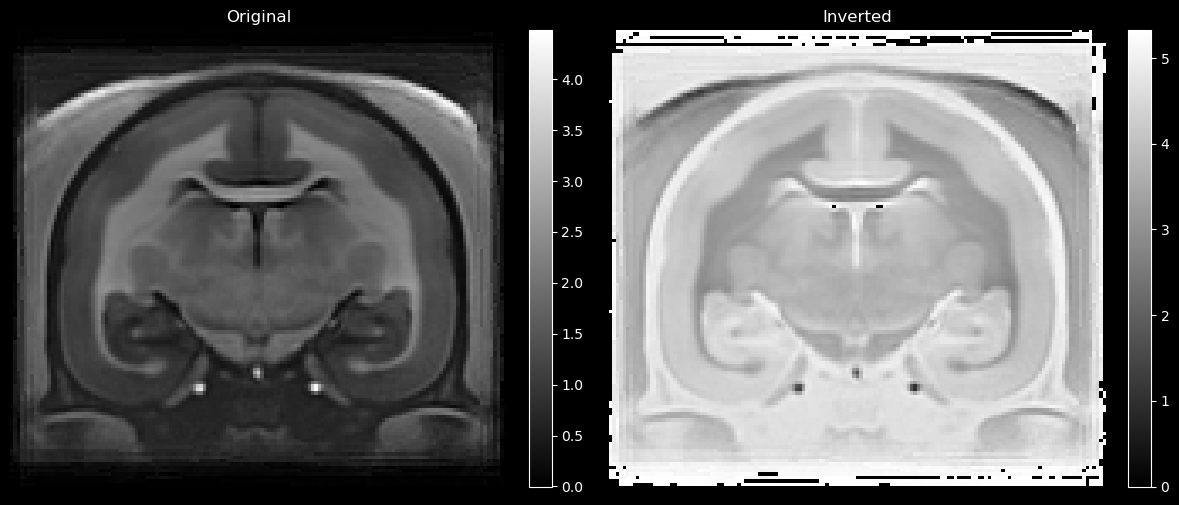

In [38]:
original_img = nib.load(os.path.join(atlas_dir, 'template_t1w.nii.gz'))
inverted_img = nib.load(os.path.join(atlas_dir, 'template_t1w_inverted.nii.gz'))

# Get the data and rotate
original_data = np.rot90(original_img.get_fdata()[:, 100, :])
inverted_data = np.rot90(inverted_img.get_fdata()[:, 100, :])

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot original image
im1 = ax1.imshow(original_data, cmap='gray')
ax1.set_title('Original')
ax1.axis('off')
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# Plot inverted image
im2 = ax2.imshow(inverted_data, cmap='gray')
ax2.set_title('Inverted')
ax2.axis('off')
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# invert the template (brain only) brightness

In [17]:

!3dcopy template_t1w_brain.nii.gz template_t1w_brain_afni

# Use subprocess to capture the output of 3dBrickStat and store it in a Python variable
result = subprocess.run(['3dBrickStat', '-max', 'template_t1w_brain_afni+orig'], stdout=subprocess.PIPE)
max_value = result.stdout.decode('utf-8').strip()  # Extract and clean the max value

# Run 3dcalc to invert the intensities using the max_value
!3dcalc -a template_t1w_brain_afni+orig -expr "step(a)*({max_value}-a)" -prefix template_t1w_brain_inverted

# Convert the final AFNI file back to NIfTI
!3dAFNItoNIFTI -prefix template_t1w_brain_inverted.nii.gz template_t1w_brain_inverted+orig

++ 3dcopy: AFNI version=AFNI_24.1.16 (Jun  6 2024) [64-bit]
++ 3dcalc: AFNI version=AFNI_24.1.16 (Jun  6 2024) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset ./template_t1w_brain_inverted+orig.BRIK
++ 3dAFNItoNIFTI: AFNI version=AFNI_24.1.16 (Jun  6 2024) [64-bit]


# Resample (discard)

try to resample the ct (1, 1, 1) to the template space (0.2, 0.2, 0.2) failed

Original CT shape: (163, 212, 232), New CT shape: (815, 1060, 1160). horrible


In [18]:
# import os

# # Assuming the paths for the CT and T1 template images
# ct_image = os.path.join(ct_dir, 'MASK_Marmoset1_skull_200micron_DSPH.nii.gz')
# t1_template = os.path.join(atlas_dir, 'template_t1w.nii.gz')
# output_image = os.path.join(ct_dir, 'MASK_Marmoset1_skull_ct_2mm_resampled_to_T1.nii.gz')

# # Run the antsApplyTransforms command in Jupyter
# !antsApplyTransforms -d 3 \
#     -i {ct_image} \
#     -r {t1_template} \
#     -o {output_image} \
#     --float \
#     --verbose


Using single precision for computations.
Input scalar image: /Users/yibeichen/Desktop/fusi/microCT/MASK_Marmoset1_skull_200micron_DSPH.nii.gz
Reference image: /Users/yibeichen/Desktop/fusi/atlas/template_t1w.nii.gz
The composite transform comprises the following transforms (in order): 
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /Users/yibeichen/Desktop/fusi/microCT/MASK_Marmoset1_skull_ct_2mm_resampled_to_T1.nii.gz


# animal warper (rigid)


In [23]:
import os

ct_image = os.path.join(ct_dir, 'MASK_Marmoset1_skull_200micron_DSPH.nii.gz')
t1_template = os.path.join(atlas_dir, 'template_t1w_inverted.nii.gz')
mask_file = os.path.join(atlas_dir, 'template_t1w_brain_inverted.nii.gz')
output_prefix = os.path.join(ct_dir, 'aligned_results')  # Specify output directory and prefix

# Ensure the output directory exists
output_dir = os.path.join(atlas_dir, 'aligned_results')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

os.chdir(ct_dir)
# Run the animal_warper alignment command
!@animal_warper -base {t1_template} \
               -input {ct_image} \
               -skullstrip {mask_file} \
               -align_type rigid \
               -cost nmi \
               -outdir {output_dir}


align_type set to rigid
++ Start @animal_warper, ver = 3.61
++ Prepare for running @djunct_overlap_check (ver = 0.46)
++ 3dcalc: AFNI version=AFNI_24.1.16 (Jun  6 2024) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset /Users/yibeichen/Desktop/fusi/atlas/aligned_results/QC/__workdir_olap_4gEHZ5r9ODt/olapch_0_cp_ulay.nii
++ Just copy olay, bc ulay will get regridded
++ 3dcalc: AFNI version=AFNI_24.1.16 (Jun  6 2024) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset /Users/yibeichen/Desktop/fusi/atlas/aligned_results/QC/__workdir_olap_4gEHZ5r9ODt/olapch_1_cp_olay.nii
++ Quietly run: 3drefit -space ORIG olapch_0_cp_ulay.nii


++ olay_alpha has known value: No



++ My command:
   @chauffeur_afni -ulay olapch_0_cp_ulay.nii -pass -pass -olay olapch_1_cp_olay.nii -ulay_range 0% 98% -func_range_perc_nz 98 -cbar Reds_and_Blues -pbar_posonly -set_subbricks 0 0 0 -olay_alpha No -olay_boxed No -opacity 3 -zerocolor black -prefix img00 -montx 1 -monty 1 -montgap 1 -montco

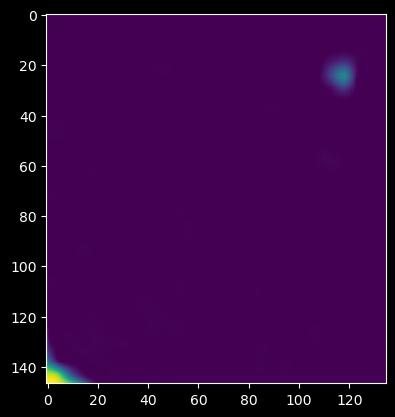

In [31]:
# plot the aligned results using imshow
import matplotlib.pyplot as plt
output_dir = os.path.join(atlas_dir, 'aligned_results')
file_path = os.path.join(output_dir, 'MASK_Marmoset1_skull_200micron_DSPH_warp2std.nii.gz')
img = nib.load(file_path)
plt.imshow(img.get_fdata()[:, 100, :])
plt.show()



# animal warper (affine)

In [25]:
import os

ct_image = os.path.join(ct_dir, 'MASK_Marmoset1_skull_200micron_DSPH.nii.gz')
t1_template = os.path.join(atlas_dir, 'template_t1w_inverted.nii.gz')
mask_file = os.path.join(atlas_dir, 'template_t1w_brain_inverted.nii.gz')
output_prefix = os.path.join(ct_dir, 'aligned_results')  # Specify output directory and prefix

# Ensure the output directory exists
output_dir = os.path.join(ct_dir, 'aligned_results2')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

os.chdir(ct_dir)
# Run the animal_warper alignment command
!@animal_warper -base {t1_template} \
               -input {ct_image} \
               -skullstrip {mask_file} \
               -align_type affine \
               -cost nmi \
               -outdir {output_dir}


align_type set to affine
++ Start @animal_warper, ver = 3.61
++ Prepare for running @djunct_overlap_check (ver = 0.46)
++ 3dcalc: AFNI version=AFNI_24.1.16 (Jun  6 2024) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset /Users/yibeichen/Desktop/fusi/microCT/aligned_results2/QC/__workdir_olap_rv7A7tBsim5/olapch_0_cp_ulay.nii
++ Just copy olay, bc ulay will get regridded
++ 3dcalc: AFNI version=AFNI_24.1.16 (Jun  6 2024) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset /Users/yibeichen/Desktop/fusi/microCT/aligned_results2/QC/__workdir_olap_rv7A7tBsim5/olapch_1_cp_olay.nii
++ Quietly run: 3drefit -space ORIG olapch_0_cp_ulay.nii


++ olay_alpha has known value: No



++ My command:
   @chauffeur_afni -ulay olapch_0_cp_ulay.nii -pass -pass -olay olapch_1_cp_olay.nii -ulay_range 0% 98% -func_range_perc_nz 98 -cbar Reds_and_Blues -pbar_posonly -set_subbricks 0 0 0 -olay_alpha No -olay_boxed No -opacity 3 -zerocolor black -prefix img00 -montx 1 -monty 1 -montgap 1 

In [24]:
os.chdir(ct_dir)

# Run 3dcopy to convert NIfTI to AFNI format
!3dcopy MASK_Marmoset1_skull_200micron_DSPH.nii.gz MASK_Marmoset1_skull_200micron_DSPH_afni

# Use subprocess to capture the output of 3dBrickStat and store it in a Python variable
result = subprocess.run(['3dBrickStat', '-max', 'MASK_Marmoset1_skull_200micron_DSPH_afni+orig'], stdout=subprocess.PIPE)
max_value = result.stdout.decode('utf-8').strip()  # Extract and clean the max value

# Run 3dcalc to invert the intensities using the max_value
!3dcalc -a MASK_Marmoset1_skull_200micron_DSPH_afni+orig -expr "step(a)*({max_value}-a)" -prefix MASK_Marmoset1_skull_200micron_DSPH_inverted

# Convert the final AFNI file back to NIfTI
!3dAFNItoNIFTI -prefix MASK_Marmoset1_skull_200micron_DSPH_inverted.nii.gz MASK_Marmoset1_skull_200micron_DSPH_inverted+orig


++ 3dcopy: AFNI version=AFNI_24.1.16 (Jun  6 2024) [64-bit]
++ 3dcalc: AFNI version=AFNI_24.1.16 (Jun  6 2024) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset ./MASK_Marmoset1_skull_200micron_DSPH_inverted+orig.BRIK
++ 3dAFNItoNIFTI: AFNI version=AFNI_24.1.16 (Jun  6 2024) [64-bit]


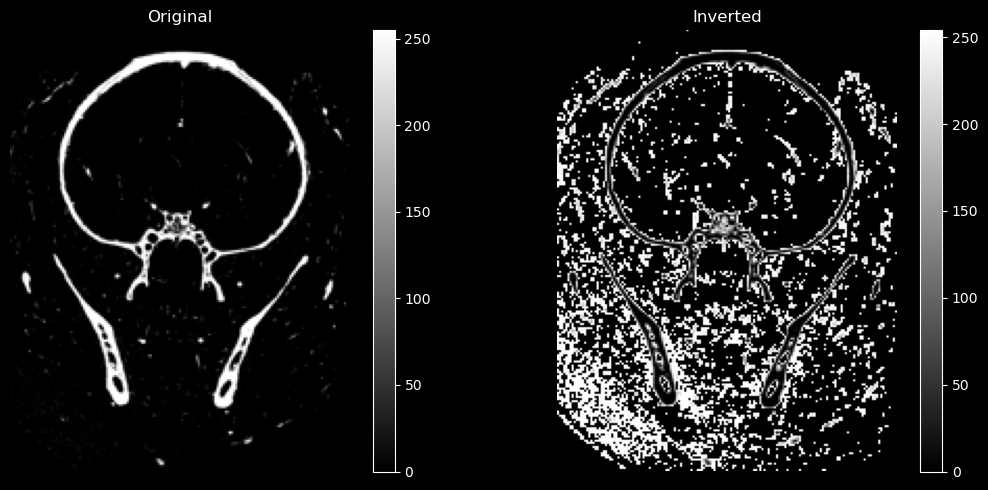

In [39]:
original_img = nib.load(os.path.join(ct_dir, 'MASK_Marmoset1_skull_200micron_DSPH.nii.gz'))
inverted_img = nib.load(os.path.join(ct_dir, 'MASK_Marmoset1_skull_200micron_DSPH_inverted.nii.gz'))

# Get the data and rotate
original_data = np.rot90(original_img.get_fdata()[:, 100, :])
inverted_data = np.rot90(inverted_img.get_fdata()[:, 100, :])

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot original image
im1 = ax1.imshow(original_data, cmap='gray')
ax1.set_title('Original')
ax1.axis('off')
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# Plot inverted image
im2 = ax2.imshow(inverted_data, cmap='gray')
ax2.set_title('Inverted')
ax2.axis('off')
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()